In [1]:
%matplotlib notebook

In [2]:
from matplotlib import animation
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import pandas
import glob
import numpy as np
import datetime
from mpl_toolkits.basemap import Basemap, shiftgrid, addcyclic
from matplotlib.colors import LinearSegmentedColormap # for custom cmap

In [3]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-webm;base64,{0}" type="video/webm">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.webm') as f:
            anim.save(f.name, fps=6, extra_args=['-vcodec', 'libvpx'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

In [3]:
from IPython.display import HTML

#def display_animation(anim):
#    plt.close(anim._fig)
#    return HTML(anim_to_html(anim))

In [4]:
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.  # knots to m/s

In [5]:
hurName='ingrid'

In [6]:
PATH='/DATA/critechuser/HWRF/{}/'.format(hurName)

## BASIN SCALE

Read data

In [8]:
dstamp=glob.glob(PATH+'*d123*.npz')

sort the files in terms of date

In [9]:
dstamp.sort()
dstamp

['/DATA/critechuser/HWRF/INVEST91L/invest91l.meteo.d123.2016052518.npz',
 '/DATA/critechuser/HWRF/INVEST91L/invest91l.meteo.d123.2016052600.npz']

### define dstamp

In [10]:
k=0

In [11]:
dat=np.load(dstamp[k])
print dat.files


['lat', 'p', 'lon', 'u', 'v']


In [12]:
tstamp=dstamp[k].split('.')[-2]

date=datetime.datetime.strptime(tstamp,"%Y%m%d%H")
date

datetime.datetime(2016, 5, 25, 18, 0)

### define forecast time

In [13]:
kf=10

In [14]:
#define variables
slp=dat['p'][kf,:,:]
lons=dat['lon']
lats=dat['lat']
u=dat['u'][kf,:,:]
v=dat['v'][kf,:,:]
date=datetime.datetime.strptime(dstamp[k].split('.')[-2],"%Y%m%d%H")

lonc=lons.mean()
latc=lats.mean()


fill_value=slp.max()
iframes=dat['p'][:].shape[0]




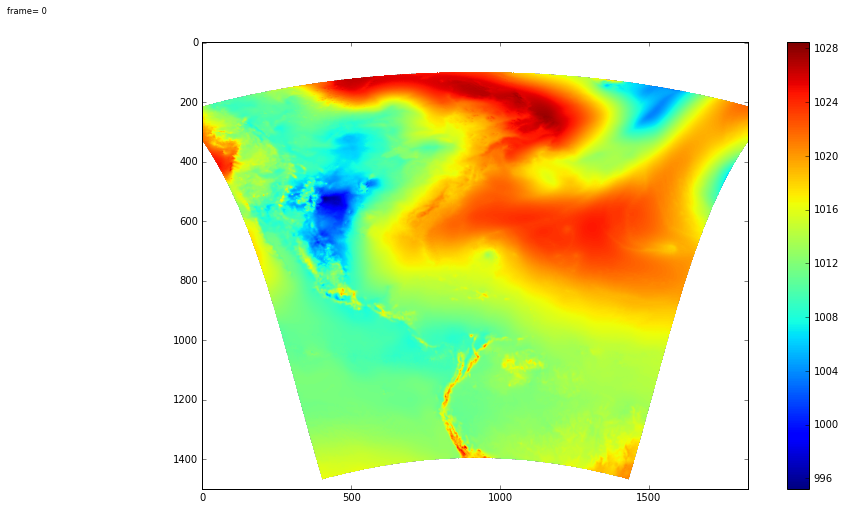

In [15]:
fig = plt.figure(figsize=(14,8))
bh=np.ma.masked_array(slp,slp==fill_value)
H=plt.imshow(bh,animated=True)
cb=plt.colorbar(H)
fig.text(.01,.95,'frame= '+np.str(0),horizontalalignment='left',size='small')
plt.show()

visualize on map

In [16]:
mlats=np.flipud(lats)
mslp=np.flipud(slp)
mu=np.flipud(u)
mv=np.flipud(v)
bh=np.ma.masked_array(mslp,mslp==fill_value)
uh=np.ma.masked_array(mu,mu==fill_value)
vh=np.ma.masked_array(mv,mv==fill_value)

longitudes=lons[0,:]
latitudes=mlats[:,0]

minlat=latitudes.min()
maxlat=latitudes.max()
minlon=longitudes.min()
maxlon=longitudes.max()

utot=np.sqrt(uh**2+vh**2)
vg=utot/kt2ms

In [17]:
wlevs = [20.,35.,50.,65.] #specify color map to match NOAA's HWRF
mapr = [(0.,'w'),(20./65.,'b'),(35./65.,'green'),(50./65.,'orange'),(1.,'purple')]
cmap = LinearSegmentedColormap.from_list('mycmap',mapr)


In [18]:
def viewdata(latc=60,lonc=-60):


    # make orthographic basemap.
    m = Basemap(resolution='l',projection='cyl',\
                llcrnrlon=minlon,urcrnrlon=maxlon,llcrnrlat=minlat,urcrnrlat=maxlat)
    # create figure, add axes
    fig1 = plt.figure(figsize=(12,10))
    ax = fig1.add_axes([0.1,0.1,0.8,0.8])
    # set desired contour levels.
    clevs = np.arange(960,1061,4)

    # compute native x,y coordinates of grid.
    x, y = m(lons, mlats)
    # define parallels and meridians to draw.
    parallels = np.arange(-80.,90,20.)
    meridians = np.arange(0.,360.,20.)
    
    # plot SLP contours.
    CS1 = m.contour(x,y,bh,clevs,linewidths=0.5,colors='k',animated=True)
    CS2 = m.contourf(x,y,vg,wlevs,cmap=cmap,animated=True,extend='both')

    zc=CS1.collections
    plt.setp(zc,linewidth=2)

    plt.clabel(CS1,clevs,inline=1,fmt='%4i',fontsize=14)

    # plot barbs
    
    yy = np.arange(0, mlats.shape[0], 50)
    xx = np.arange(0, lons.shape[1], 50)

    points = np.meshgrid(yy, xx)

    m.barbs(lons[points], mlats[points], uh[points], vh[points], 
      pivot='middle', barbcolor='#333333',barb_increments=dict(half=5, full=10, flag=20))

    
    # plot Vectors 
   # step=20
   # Q = m.quiver(x[::step,::step],y[::step,::step],uh[::step,::step],vh[::step,::step],scale=1000)
    # make quiver key.
   # qk = plt.quiverkey(Q, 0.1, 0.1, 20, '20 m/s', labelpos='W')
    # draw coastlines, parallels, meridians.
    m.drawcoastlines(linewidth=1.5)
    m.drawparallels(parallels)
    m.drawmeridians(meridians)
    # add colorbar
    cb = m.colorbar(CS2,"right", size="3%", pad="2%")
    cb.set_label('10m Wind (kts)')
    # set plot title
    plt.title('NCEP HWRF - {} {} - F{:03d}'.format(hurName,tstamp,kf*3),fontsize=20)
    plt.figtext(0.15,0.05,'MSLP (mb,contour) & 10m Winds (kts,shaded)  MAX 10m wind (kt):{}'.format(np.str(vg.max())),fontsize=18)
    plt.show()

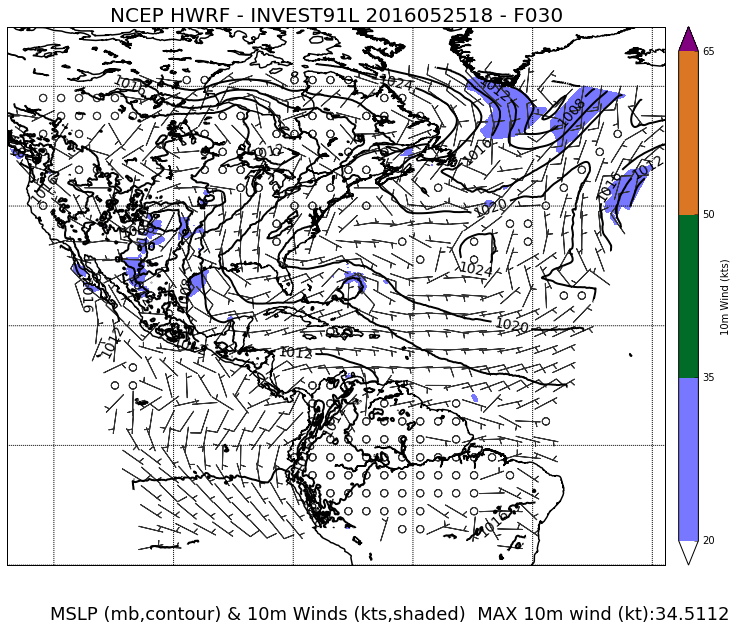

In [19]:
viewdata(latc=latc,lonc=lonc)

In [20]:
%%skip
#with cartopy
import cartopy
import cartopy.crs as ccrs

crs = ccrs.RotatedPole(pole_longitude=lonc,pole_latitude=latc)
#crs=ccrs.Orthographic(lonc,latc)

fig = plt.figure(figsize=(8,10))
ax = fig.add_axes()
ax = plt.axes(projection=ccrs.Orthographic(lonc,latc))
#ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.OCEAN, zorder=0)
ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

ax.set_global()
ax.gridlines()

ax.quiver(lons[::30,::30],lats[::30,::30],uh[::30,::30],vh[::30,::30],transform=crs)

plt.show()


## STORM SCALE

lets import the hight resolution storm centeded data

In [21]:
d3stamp=glob.glob(PATH+'*d3*.npz')

In [22]:
d3stamp.sort()
d3stamp

['/DATA/critechuser/HWRF/INVEST91L/invest91l.meteo.d3.2016052518.npz',
 '/DATA/critechuser/HWRF/INVEST91L/invest91l.meteo.d3.2016052600.npz']

In [23]:
dat3=np.load(d3stamp[k])
print dat3.files


['lat', 'p', 'lon', 'u', 'v']


In [24]:
#Choose forecast

kf=10

In [25]:
#define variables
slp=dat3['p'][kf,:,:]
longitude=dat3['lon'][kf,:]
latitude=dat3['lat'][kf,:]
u=dat3['u'][kf,:,:]
v=dat3['v'][kf,:,:]

lonc=longitude.mean()
latc=latitude.mean()

lons,lats=np.meshgrid(longitude,latitude)

fill_value=slp.max()
iframes=dat3['p'][:].shape[0]

mlats=np.flipud(lats)
bh=np.ma.masked_array(np.flipud(slp),np.flipud(slp)==fill_value)
uh=np.ma.masked_array(np.flipud(u),np.flipud(u)==fill_value)
vh=np.ma.masked_array(np.flipud(v),np.flipud(v)==fill_value)

vtot=np.sqrt(uh**2+vh**2)



In [26]:
def graph(dat,var,title):

 fig = plt.figure(figsize=(8,10))
 m = Basemap(projection='cyl',llcrnrlat=mlats.min(),urcrnrlat=mlats.max(),\
             llcrnrlon=lons.min(),urcrnrlon=lons.max(),resolution='l')

 parallels = np.arange(-90.,90,20.)
 meridians = np.arange(0.,360.,20.)

 clevs = 20

 CS1 = m.contour(lons,mlats,dat,clevs,linewidths=0.5,colors='k',animated=True)
 CS2 = m.contourf(lons,mlats,dat,clevs,cmap=plt.cm.RdBu_r,animated=True)

 m.drawcoastlines(linewidth=1.5)
 m.drawparallels(parallels)
 m.drawmeridians(meridians)
    # add colorbar
 cb = m.colorbar(CS2,"right", size="5%", pad="2%")
 cb.set_label(var)
    # set plot title
 plt.title('{}   {}'.format(title,date))
 plt.show()

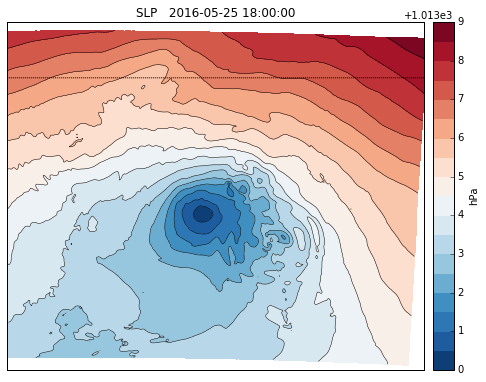

In [27]:
graph(bh,'hPa','SLP')

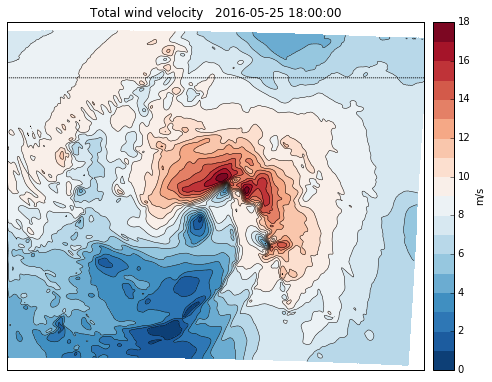

In [28]:
graph(vtot,'m/s','Total wind velocity')

Compare with HWRF graph

In [29]:
wlevs = [20.,34.,64.,83.,96.,114.,137.] #specify color map to match NOAA's HWRF
mapr = [(0.,'w'),(20./137.,'b'),(34./137.,'cyan'),(64./137.,'green'),(83./137.,'y'),(96./137.,'orange'),(114./137.,'magenta'),(1.,'purple')]
cmap = LinearSegmentedColormap.from_list('mycmap',mapr)


In [30]:
vg=vtot/kt2ms # convert to kts

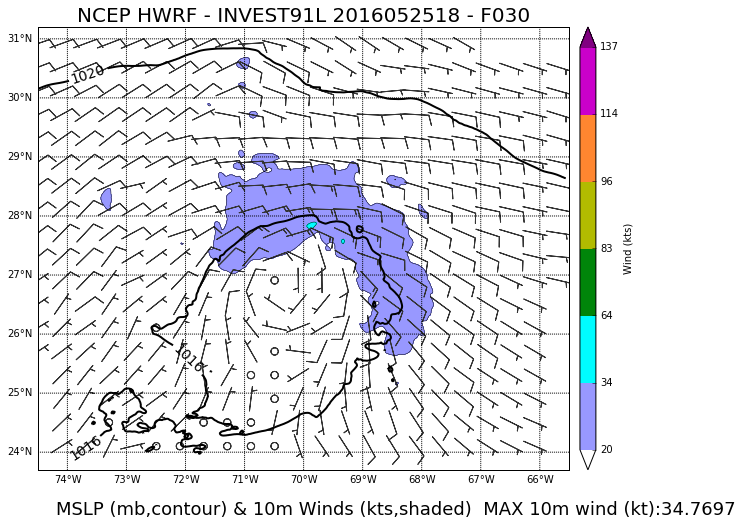

In [31]:
fig = plt.figure(figsize=(10,8))
m = Basemap(projection='cyl',llcrnrlat=mlats.min(),urcrnrlat=mlats.max(),\
             llcrnrlon=lons.min(),urcrnrlon=lons.max(),resolution='l')

parallels = np.arange(-90.,90,1.)
meridians = np.arange(0.,360.,1.)

plevs=np.arange(992,1028,4)

CS1 = m.contour(lons,mlats,vg,wlevs,linewidths=0.5,colors='k',animated=True)
CS2 = m.contourf(lons,mlats,vg,wlevs,cmap=cmap, animated=True,extend='both')
CS3 = m.contour(lons,mlats,bh,plevs,linewidths=0.5,colors='k',animated=True)

zc=CS3.collections
plt.setp(zc,linewidth=2)

plt.clabel(CS3,plevs,inline=1,fmt='%4i',fontsize=14)

yy = np.arange(0, mlats.shape[0], 20)
xx = np.arange(0, lons.shape[1], 20)

points = np.meshgrid(yy, xx)

m.barbs(lons[points], mlats[points], uh[points], vh[points], 
    pivot='middle', barbcolor='#333333',barb_increments=dict(half=5, full=10, flag=20))

m.drawcoastlines(linewidth=0.5)
m.drawparallels(parallels,labels=[True,False,False,True])
m.drawmeridians(meridians,labels=[True,False,False,True])
    # add colorbar
cb = m.colorbar(CS2,"right", size="3%", pad="2%")
cb.set_label('Wind (kts)')
    # set plot title
plt.title('NCEP HWRF - {} {} - F{:03d}'.format(hurName,tstamp,kf*3),fontsize=20)
plt.figtext(0.15,0.05,'MSLP (mb,contour) & 10m Winds (kts,shaded)  MAX 10m wind (kt):{}'.format(np.str(vg.max())),fontsize=18)
plt.show()

## Animate 

In [32]:
ha=dat3['p'][:,:,:]


In [33]:
def animate(i):
   # global H
    bh=np.ma.masked_array(np.flipud(ha[i,:,:]),np.flipud(ha[i,:,:])==fill_value)
   # fig.texts.pop()
    CS3.set_array(bh)
  #  plt.title('NCEP HWRF - {} {} - F{:03d}'.format(hurName,tstamp,i),fontsize=20)
  #  plt.figtext(0.15,0.05,'MSLP (mb,contour) & 10m Winds (kts,shaded)  MAX 10m wind (kt):{}'.format(np.str(vg.max())),fontsize=18)


In [34]:
# call the animator.  blit=True means only re-draw the parts that have changed.
#anim = animation.FuncAnimation(fig, animate, frames=iframes, interval=200, blit=False)

# call our new function to display the animation
#display_animation(anim)

In [35]:
#save animation
#anim.save('webtest.mp4')

### Analysis

We can read the TC center from file .3hourly

In [36]:
trakfiles=glob.glob(PATH+'*.3hourly')
trakfiles.sort()

In [37]:
cnames=['BASIN', 'CY', 'YYYYMMDDHH', 'TECHNUM/MIN', 'TECH', 'TAU', 'LatN/S', 'LonE/W', 'VMAX', 'MSLP', 'TY', 'RAD'\
         , 'WINDCODE', 'RAD1', 'RAD2', 'RAD3', 'RAD4', 'POUTER', 'ROUTER', 'RMW', 'GUSTS', 'EYE', 'SUBREGION', \
         'MAXSEAS', 'INITIALS', 'DIR', 'SPEED', 'STORMNAME', 'DEPTH', 'SEAS', 'SEASCODE', 'SEAS1', 'SEAS2', 'SEAS3' \
         , 'SEAS4', 'USERDEFINE1', 'userdata1', 'USERDEFINE2', 'userdata2', 'USERDEFINE3', 'userdata3', 'USERDEFINE4',\
         'userdata4', 'USERDEFINE5', 'userdata5']

In [38]:
attr=pandas.read_csv(trakfiles[k],header=-1,names=cnames)

We can create a forecast table/figure for track and mslp,umax 

In [39]:
df1 = attr[['TAU','LatN/S', 'LonE/W','VMAX','MSLP','POUTER','RMW']]
df1

,TAU,LatN/S,LonE/W,VMAX,MSLP,POUTER,RMW
0,0,260N,678W,25,1017,-99,58
1,3,260N,679W,23,1015,-99,75
2,6,260N,682W,30,1016,-99,97
3,9,262N,686W,33,1016,-99,106
4,12,263N,689W,32,1015,-99,85
5,15,266N,690W,30,1015,-99,34
6,18,267N,689W,36,1015,-99,35
7,21,270N,690W,37,1015,-99,29
8,24,270N,695W,36,1013,-99,27
9,27,271N,699W,36,1013,-99,48


In [40]:
dstamp=[]
for i in attr['TAU']:
    dstamp.append(date+datetime.timedelta(hours=i))
    

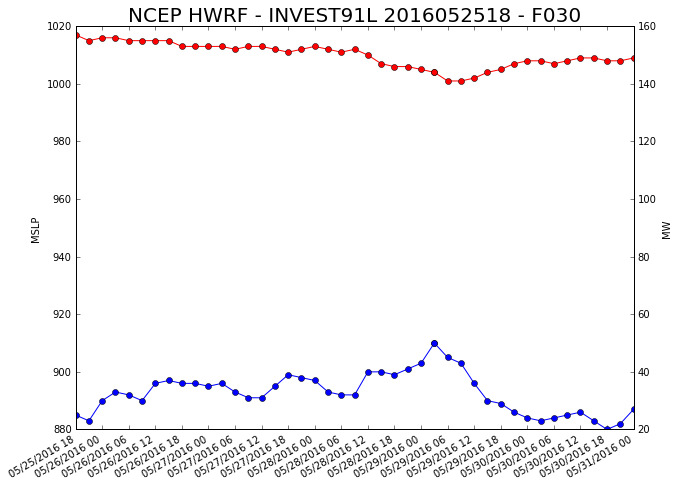

In [48]:
fig=plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=[0,6,12,18]))
ax1.xaxis_date()
    
ax1.plot(dstamp,attr['MSLP'].values,'ro-')
#ax1.plot(dstamp,penv,'kx-')
ax1.set_ybound(880,1020)
ax1.set_ylabel('MSLP')

ax2=ax1.twinx()
ax2.plot(dstamp,attr['VMAX'].values,'bo-')
ax2.set_ylabel('MW')
ax2.set_ybound(20,160)

plt.gcf().autofmt_xdate()
plt.title('NCEP HWRF - {} {} - F{:03d}'.format(hurName,tstamp,kf*3),fontsize=20)
plt.show()

and the track

We can already define the Holland that fits this storm

In [43]:
df2 = attr[['MSLP','RMW', 'VMAX']]
df2['DP']= pandas.Series(1010-df2['MSLP'], index=df2.index)

df2

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,MSLP,RMW,VMAX,DP
0,1017,58,25,-7
1,1015,75,23,-5
2,1016,97,30,-6
3,1016,106,33,-6
4,1015,85,32,-5
5,1015,34,30,-5
6,1015,35,36,-5
7,1015,29,37,-5
8,1013,27,36,-3
9,1013,48,36,-3


In [44]:
rhoa=1.15 #air density  Kg/m^3
dp=df2['DP'][kf]*100. # convert to PA
print 'DP={} [PA]'.format(dp)
vm=df2['VMAX'][kf]*kt2ms #convert to  m/s
vm=vm*.9 # convert to 10m average
print 'Vmax={} [m/s]'.format(vm)
b0=vm**2*rhoa*np.exp(1.)/dp #Eq (7) from JRC report
print 'B={}'.format(b0)
rmw=df2['RMW'][kf]*nm2m # convert to m
print 'Rmax={} [m]'.format(rmw)

DP=-300.0 [PA]
Vmax=16.205 [m/s]
B=-2.73633419858
Rmax=85192.0 [m]


In [45]:
#Define the Holland equation
maxR=500.e3  # maximum radius of TC [m] (500Km)

def Holland(r,b,rmax,deltap,k):
    x=0.5#+(r-rmax)/(maxR-rmax)*k 
    return (b/rhoa*(rmax/r)**b*deltap*np.exp(-(rmax/r)**b))**x # Eq (9) from report


In [46]:
vel2=np.zeros(201)
rr=np.linspace(2.,maxR,201)  
for l in range(201):
    r=rr[l] 
    vel2[l]=Holland(r,b0,rmw,dp,0.)

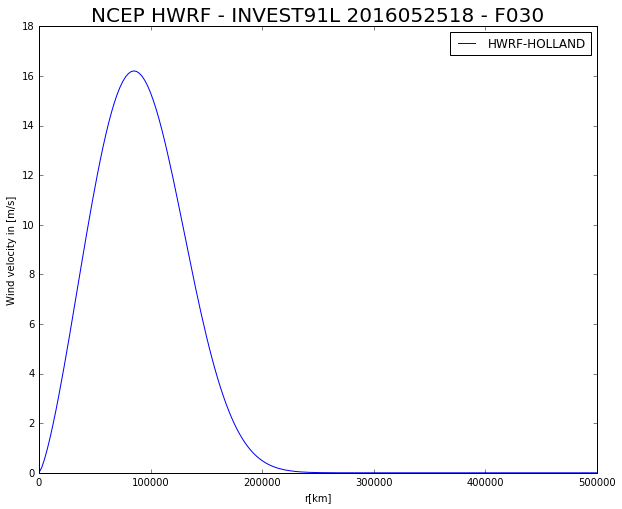

In [49]:
fig = plt.figure(figsize=(10,8))

plt.plot(rr,vel2,label='HWRF-HOLLAND')
plt.title('Total velocity [10m averaged] vs R')
plt.xlabel('r[km]')
plt.ylabel('Wind velocity in [m/s]')
plt.legend()
plt.title('NCEP HWRF - {} {} - F{:03d}'.format(hurName,tstamp,kf*3),fontsize=20)
plt.show()